<strong><h1 align = center><font size = 6>Emotion Detection from Text</font></h1></strong>

# __1. Importing the necessary libraries.__

In [1]:
! pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [4]:
from google.colab import files
uploaded = files.upload()

Saving emotion_data.csv to emotion_data.csv


In [5]:
ls

emotion_data.csv  sample_data/


# __2. Preprocessing the Text__

In [6]:
df = pd.read_csv('/content/emotion_data.csv', names=['id', 'text', 'category'])
df.set_index('id', inplace=True)

In [8]:
df.head(10)

,text,category
id,,
1,i m looking forward to going home tomorrow but...,sad
2,just got to kansas city and excited for a fun ...,love
3,hey adt guess what my princelple s number plat...,happy
4,b gt not the best song for her,neutral
5,the wind tried to hate on us today lol hello f...,anger
6,i need to change my ways instead of just being...,love
7,i am so excited rob thomas is back,happy
8,feeling the pain from the accidente not feelin...,sad
9,it rains and it sucks so much because it s the...,sad


$\color{red}{\textbf{NOTE:}}$ `id` is in bold because we set it as an __index__, So its no longer a data in the actual dataframe 

In [9]:
df.category.value_counts() # it counts How many times each unique instance occur in your data

sad        16251
happy      15444
neutral     9643
love        8248
anger       6188
Name: category, dtype: int64

In [10]:
# Removing the tweet with multiple category/nocode
df = df[~df.category.str.contains('\|')

SyntaxError: ignored

In [11]:
df = df[df.category != 'nocode']

In [12]:
df.category.value_counts()

sad        16251
happy      15444
neutral     9643
love        8248
anger       6188
Name: category, dtype: int64

In [13]:
possible_labels = df.category.unique() # Now we have the list that conatin all-of the labels

In [14]:
label_dict = {} # Creating an empty Dict, & Looping over the possible labels 
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [15]:
label_dict

{'sad': 0, 'love': 1, 'happy': 2, 'neutral': 3, 'anger': 4}

In [16]:
df['label'] = df.category.replace(label_dict)

In [17]:
df.head(10)

,text,category,label
id,,,
1,i m looking forward to going home tomorrow but...,sad,0
2,just got to kansas city and excited for a fun ...,love,1
3,hey adt guess what my princelple s number plat...,happy,2
4,b gt not the best song for her,neutral,3
5,the wind tried to hate on us today lol hello f...,anger,4
6,i need to change my ways instead of just being...,love,1
7,i am so excited rob thomas is back,happy,2
8,feeling the pain from the accidente not feelin...,sad,0
9,it rains and it sucks so much because it s the...,sad,0


# __3. Training/Validation Split__

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x_train, x_val, y_train, y_val =  train_test_split(df.index.values,
                                                   df.label.values,
                                                   test_size=0.15,
                                                   random_state=17,
                                                   stratify=df.label.values
)

In [20]:
# Creating the New column in our dataframe --> 'data_type'
# data_type is Initally 'not_set' for all the samples
df['data_type'] = ['not_set']*df.shape[0]

In [21]:
df.head()

,text,category,label,data_type
id,,,,
1,i m looking forward to going home tomorrow but...,sad,0,not_set
2,just got to kansas city and excited for a fun ...,love,1,not_set
3,hey adt guess what my princelple s number plat...,happy,2,not_set
4,b gt not the best song for her,neutral,3,not_set
5,the wind tried to hate on us today lol hello f...,anger,4,not_set


In [22]:
df.loc[x_train, 'data_type'] = 'train'
df.loc[x_val, 'data_type'] = 'val'

In [23]:
df.groupby(['category', 'label', 'data_type']).count()

text
category label data_type       
anger    4     train       5258
               val          928
happy    2     train      13123
               val         2317
love     1     train       7007
               val         1237
neutral  3     train       8139
               val         1433
sad      0     train      13806
               val         2436

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
vectorizer = CountVectorizer()


In [25]:
x_tr = vectorizer.fit_transform(df[df.data_type=='train'].text.values.astype('U')) 
# vectorizer.fit(df[df.data_type=='train'].text.values)

In [26]:
X_test = vectorizer.transform((df[df.data_type=='val'].text.values.astype('U')))


# __4. Logistic Regression__

In [28]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000)
model.fit(x_tr, df[df.data_type=='train'].category.values)

LogisticRegression(max_iter=100000, multi_class='multinomial')

In [29]:
score = model.score(X_test, df[df.data_type=='val'].category.values)

In [30]:
print("Accuracy:", score)

Accuracy: 0.5926855503764791


In [34]:

predictions = model.predict(X_test)
cnf_matrix = confusion_matrix(df[df.data_type=='val'].category.values, predictions)

In [35]:
classes = ["Sad", "Love", "Happy", "Neutral", "Anger"]

In [36]:
print(classification_report(df[df.data_type=='val'].category.values,predictions, target_names=classes))

              precision    recall  f1-score   support

         Sad       0.85      0.76      0.81       928
        Love       0.56      0.58      0.57      2317
       Happy       0.72      0.61      0.66      1237
     Neutral       0.42      0.43      0.43      1447
       Anger       0.58      0.63      0.60      2438

    accuracy                           0.59      8367
   macro avg       0.63      0.60      0.61      8367
weighted avg       0.60      0.59      0.59      8367



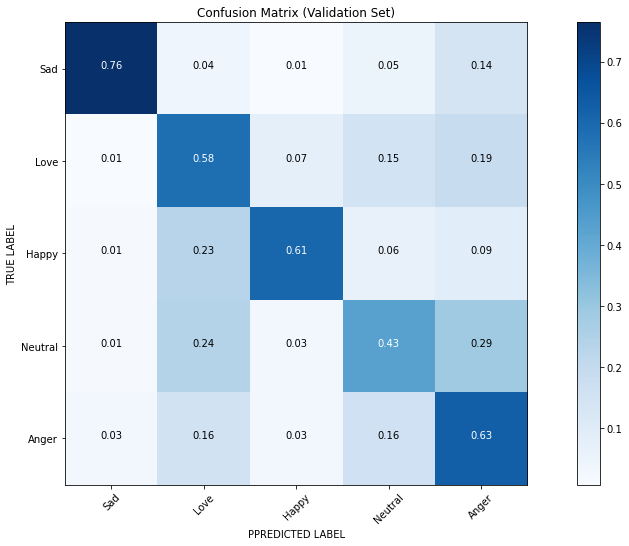

In [37]:
import numpy as np
import itertools, pickle

def plot_confusion_matrix(cm, labels, normalize=True, title='Confusion Matrix (Validation Set)', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('TRUE LABEL')
    plt.xlabel('PPREDICTED LABEL')

plt.figure(figsize=(14,7.5))
plot_confusion_matrix(cnf_matrix, labels=classes)